# Simple DAS plotting
This script aims for quick plotting of DAS data.

In [6]:

# import packages
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import sys
sys.path.append("../utils/")
import DASfuncs
import getDTSdata
from tqdm import tqdm

%matplotlib widget

In [7]:
dts_time, dts_dist, dts_data = getDTSdata.getDTSdata()
plt.ion()

In [8]:
# get files
t_start = datetime.datetime(2023,8,25)
t_end = datetime.datetime(2023,8,30)
path = '../data/DAS/data_1Hz'
files = DASfuncs.get_Onyx_h5(path, t_start, t_end)
print('{} files in directory'.format(len(files)))

112 files in directory


In [9]:
# read the data
time_read, data_read, attrs_read = DASfuncs.read_Onyx_h5_to_list(files, cha_start=None, cha_end=None, t_start=t_start, t_end=t_end, verbose=True)
# concatenate files
t_rec, data_rec, attrs = DASfuncs.comb_Onyx_data(time_read, data_read, attrs_read)

Problems with: ../data/DAS/data_1Hz/decimator3_2023-08-15_12.02.22_UTC.h5
Unable to open file (bad object header version number)


In [10]:
# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')

In [11]:
# filtering
sos = scipy.signal.butter(2, 0.1,'lowpass', fs=attrs['PulseRate'], output='sos')
filt_list = [DASfuncs.apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list]

In [12]:
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, filt_list, attrs, t_format='datetime')

In [13]:
data_arr = data_filled
times = DASfuncs.sintela_to_datetime(t_rec)  # Convert timestamp to datetime
dx = attrs['SpatialSamplingInterval']
chas = np.arange(attrs['StartLocusIndex'], attrs['StartLocusIndex']+attrs['NumberOfLoci'])
dists = chas*dx

In [14]:
# Slice data in time and space
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = t_start
end_time = t_end

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = data_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]

In [15]:
data_norm = plot_arr/np.median(plot_arr) #- np.nanmedian(plot_arr, axis=0)
# data_norm = data_norm / np.std(data_norm, axis=0)[None,:]
print(plot_times[0], plot_times[-1])
print(np.shape(data_norm))
# Normalize 
for i in range(len(data_norm[:, 0])):
    data_norm[i, :] = (data_norm[i, :] - np.nanmedian(data_norm[i, :]))/(np.nanstd(data_norm[i, :]))

2023-08-25 00:13:10 2023-08-29 14:25:56
(396767, 69)


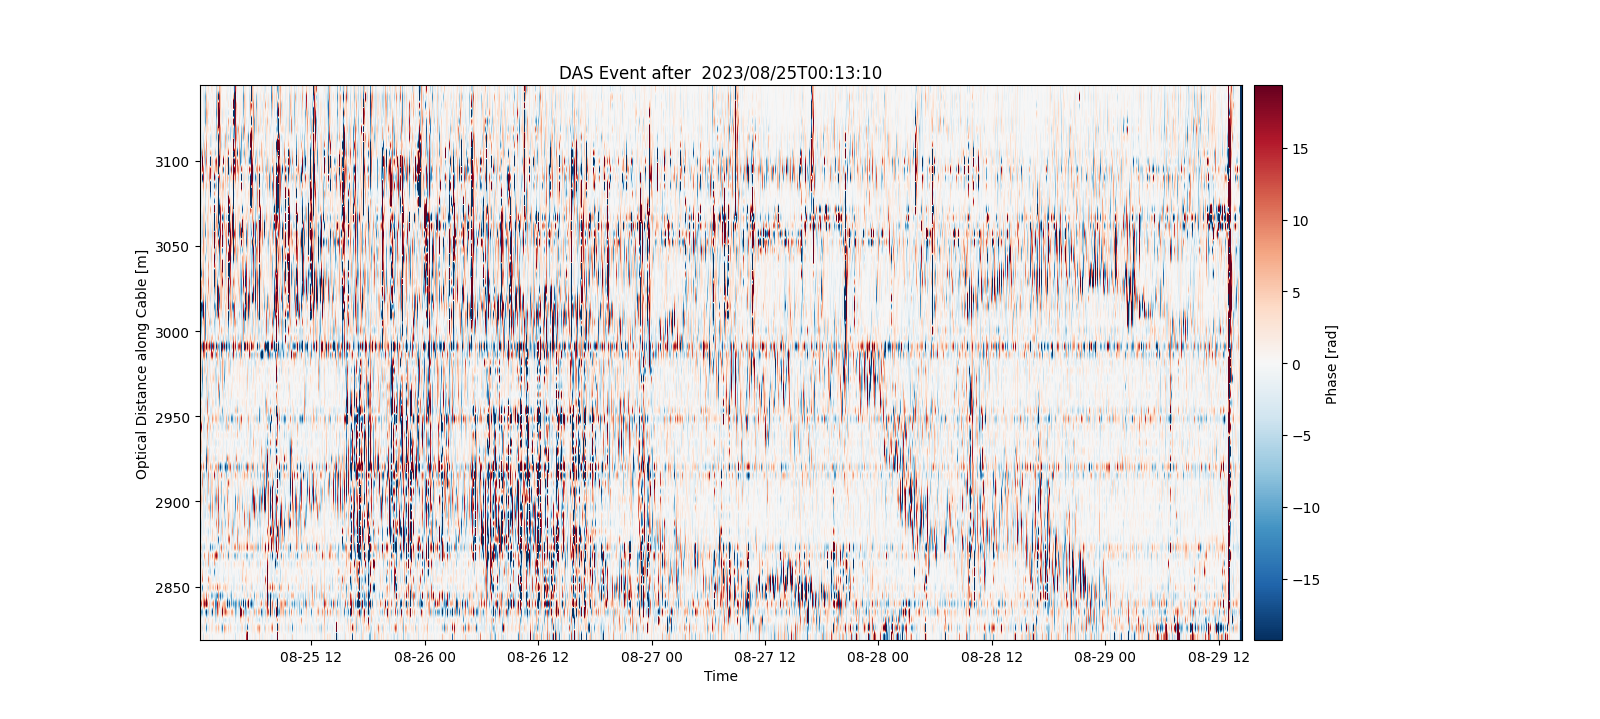

In [18]:
# Plot
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

im = ax.imshow(plot_arr.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(plot_arr[~np.isnan(plot_arr)],5),
             vmax=np.percentile(plot_arr[~np.isnan(plot_arr)],95),
             extent=[plot_times[0], plot_times[-1],
                  plot_dists[0], plot_dists[-1]],
             cmap='RdBu_r',
             # interpolation='none',
               zorder=0
             )

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
ax.set_title('DAS Event after  {}'.format(plot_times[0].strftime("%Y/%m/%dT%H:%M:%S")))

cbar = fig.colorbar(im, pad=0.01)
cbar.set_label('Phase [rad]')


In [162]:
# Recall plot_times, plot_dists


dts_timeint = dts_time.astype(int)
das_timeint = pd.DatetimeIndex(plot_times)
das_timeint = das_timeint.astype(int)
dts_deriv = np.gradient(dts_data, axis=0)

# Apply gaussian filter to the vertical componets of dts_data
for i in range(len(dts_data[:, 0])):
    dts_deriv[i, :] = scipy.ndimage.gaussian_filter(dts_deriv[i, :], sigma=5)

points = (dts_dist, dts_timeint)
pointsinterp = (das_timeint, plot_dists)
dts_interp = np.empty(np.shape(data_norm))
print(np.shape(dts_interp), len(das_timeint), len(plot_dists))
points_interp = np.meshgrid(plot_dists, das_timeint)
dts_interp = scipy.interpolate.interpn(points, dts_deriv.T, points_interp, bounds_error=False)

print(np.shape(dts_interp))
# Normalize 
for i in range(len(dts_interp[:, 0])):
    dts_interp[i, :] = (dts_interp[i, :] - np.nanmedian(dts_interp[i, :]))/(np.nanstd(dts_interp[i, :]))

(396767, 69) 396767 69
(396767, 69)


/var/folders/zd/7h901qjs6sb24r_mgjqbqp5r0000gp/T/ipykernel_79466/1142558976.py:23: RuntimeWarning: All-NaN slice encountered
  dts_interp[i, :] = (dts_interp[i, :] - np.nanmedian(dts_interp[i, :]))/(np.nanstd(dts_interp[i, :]))
/Users/ericalt/Library/Python/3.12/lib/python/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


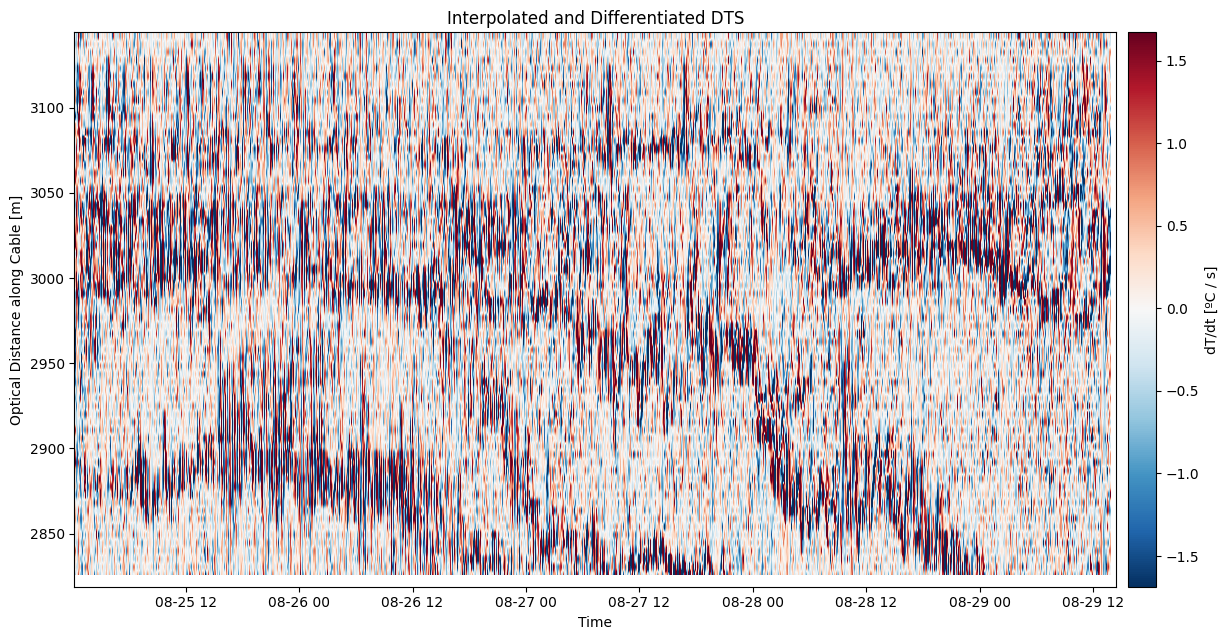

In [163]:
# Plot
fig2, ax2 = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
plotarr = dts_interp

im2 = ax2.imshow(plotarr.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(plotarr[~np.isnan(plotarr)],5),
             vmax=np.percentile(plotarr[~np.isnan(plotarr)],95),
             extent=[plot_times[0], plot_times[-1],
                  plot_dists[0], plot_dists[-1]],
             cmap='RdBu_r',
             # interpolation='none',
               zorder=0
             )

ax2.set_ylabel('Optical Distance along Cable [m]')
ax2.set_xlabel('Time')
ax2.set_title('Interpolated and Differentiated DTS')
ax2.set_xlim(pd.to_datetime("2023-08-25 00:13:10"), pd.to_datetime("2023-08-29 14:25:56"))

cbar = fig2.colorbar(im2, pad=0.01)
cbar.set_label('dT/dt [ºC / s]')

In [177]:
def residualdiff(params):
    time_offset = int(np.round(params[0]))
    dist_offset = int(np.round(params[1]))
    # print('test')
    shifted_dts = np.roll(dts_interp, dist_offset, axis=1)
    shifted_dts = np.roll(shifted_dts, time_offset, axis=0)
    residual = np.abs(data_norm - shifted_dts)
    return np.nansum(np.abs(residual))

In [180]:
resnorm1 = 1e20
resnorm2 = 0
bestt = 0
bestd = 0

# time_offset, dist_offset = scipy.optimize.minimize(residualdiff, [0, 0], args=dts_interp)
opts = {'maxiter' : 1000, 'verbose' : 3} 
bnds = ((-1000, 1000), (-5, 5))
offsets = scipy.optimize.fmin(residualdiff, [100, 0])
print(offsets)
time_offset = int(np.round(offsets[0]))
dist_offset = int(np.round(offsets[1]))
# for i in tqdm(range(15)):
#   for j in range(15):
#     time_offset = i * 20
#     dist_offset = j * 1
#     shifted_dts = np.roll(dts_interp, dist_offset, axis=1)
#     shifted_dts = np.roll(shifted_dts, time_offset, axis=0)
#     residual = np.abs(data_norm - shifted_dts)
#     resnorm2 = np.nansum(residual)
#     if(resnorm1 > resnorm2):
#       resnorm1 = resnorm2
#       bestt = time_offset
#       bestd = dist_offset
# print(bestt, bestd)

# time_offset = 400
# dist_offset = 0
shifted_dts = np.roll(dts_interp, dist_offset, axis=1)
shifted_dts = np.roll(shifted_dts, time_offset, axis=0)
residual = data_norm - shifted_dts

Optimization terminated successfully.
         Current function value: 26571549.270439
         Iterations: 36
         Function evaluations: 90
[ 4.73750e+02 -9.21875e-03]


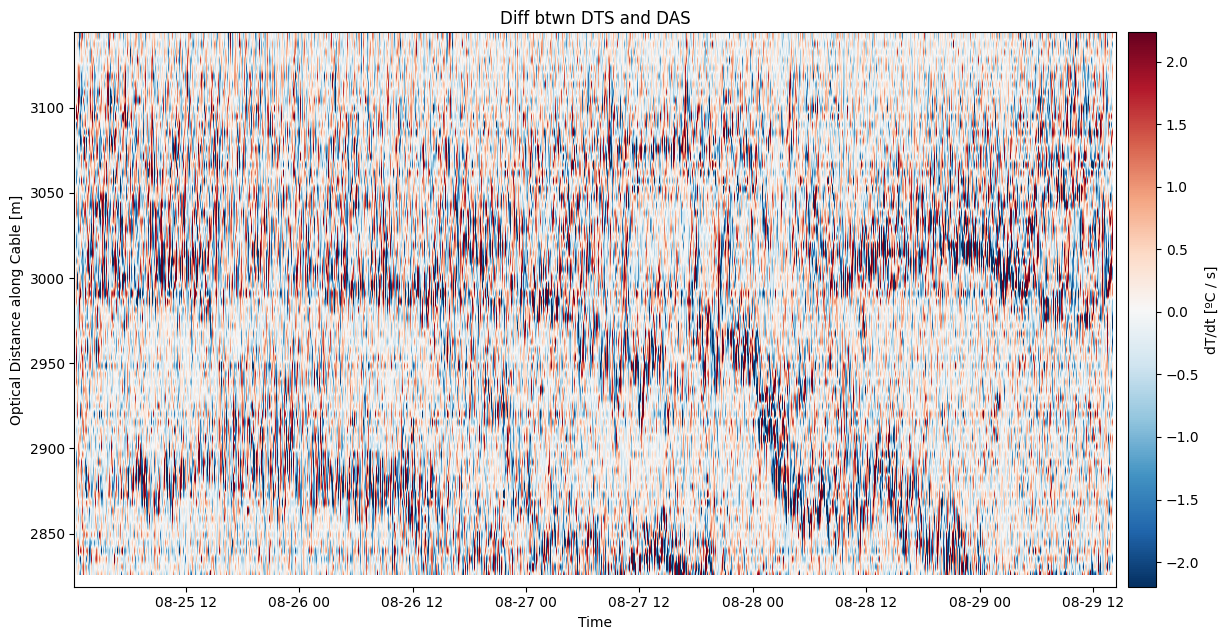

In [181]:
# Plot
fig2, ax2 = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
plotarr = residual

im2 = ax2.imshow(plotarr.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(plotarr[~np.isnan(plotarr)],5),
             vmax=np.percentile(plotarr[~np.isnan(plotarr)],95),
             extent=[plot_times[0], plot_times[-1],
                  plot_dists[0], plot_dists[-1]],
             cmap='RdBu_r',
             # interpolation='none',
               zorder=0
             )

ax2.set_ylabel('Optical Distance along Cable [m]')
ax2.set_xlabel('Time')
ax2.set_title('Diff btwn DTS and DAS')
ax2.set_xlim(pd.to_datetime("2023-08-25 00:13:10"), pd.to_datetime("2023-08-29 14:25:56"))

cbar = fig2.colorbar(im2, pad=0.01)
cbar.set_label('dT/dt [ºC / s]')

Do a spacial fourier transform of the DAS
